In [1]:
%matplotlib inline
import os
import sys
from glob import glob
import numpy as np
import pandas as pd
idx = pd.IndexSlice
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

import copy

import geopandas as gpd

from sklearn.metrics import mean_absolute_error

from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor

import gpflow
import tensorflow as tf

code_dir = '/cluster/home/kheuto01/code/zero-inflated-gp/'
sys.path.append(code_dir)

from onoffgpf import OnOffSVGPPoiMC, OnOffLikelihood
gpflow.config.default_float()

2022-09-22 11:01:35.074198: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-22 11:01:35.191803: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-09-22 11:01:35.197144: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-09-22 11:01:35.197159: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if yo

numpy.float64

In [2]:
data_dir = '/cluster/tufts/hugheslab/datasets/NSF_OD/'
result_dir = os.path.join(data_dir, 'results')
mass_shapefile = os.path.join(data_dir,'shapefiles','MA_2021')

In [3]:


svi_file = os.path.join(result_dir,'svi_qtr')
svi_gdf = gpd.read_file(svi_file)
svi_gdf = svi_gdf.rename(columns={'INTPTLAT':'lat', 'INTPTLON':'lon', 'GEOID':'grid_squar'})
# Make lat and lon floats
svi_gdf.loc[:, 'lat'] = svi_gdf.lat.astype(float)
svi_gdf.loc[:, 'lon'] = svi_gdf.lon.astype(float)
deaths_gdf = svi_gdf



In [4]:
just_grid = deaths_gdf.loc[(deaths_gdf['year']==2000)&(deaths_gdf['quarter']==4), ['grid_squar','geometry', 'lat', 'lon']]


In [5]:
from math import radians, cos, sin, asin, sqrt

def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance in kilometers between two points 
    on the earth (specified in decimal degrees)
    https://stackoverflow.com/a/4913653/1748679
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 6371 # Radius of earth in kilometers. Use 3956 for miles. Determines return value units.
    return c * r

In [6]:
just_grid

,grid_squar,geometry,lat,lon
4860,25017333300,"POLYGON ((-71.16139 42.47071, -71.16136 42.471...",42.470764,-71.152055
4861,25017333400,"POLYGON ((-71.14690 42.48077, -71.14673 42.480...",42.484548,-71.132032
4862,25017333502,"POLYGON ((-71.15960 42.48482, -71.15954 42.484...",42.485040,-71.146119
4863,25017354500,"POLYGON ((-71.13077 42.38261, -71.13070 42.382...",42.384745,-71.125040
4864,25017354700,"POLYGON ((-71.12901 42.39007, -71.12768 42.389...",42.389581,-71.122629
...,...,...,...,...
6475,25009208302,"POLYGON ((-71.01723 42.48901, -71.01705 42.489...",42.485038,-71.004081
6476,25009212101,"POLYGON ((-71.05565 42.62288, -71.05509 42.625...",42.613694,-71.005231
6477,25009208401,"POLYGON ((-71.04695 42.48796, -71.04672 42.488...",42.487612,-71.030763
6478,25009208402,"POLYGON ((-71.05389 42.47878, -71.05373 42.479...",42.466251,-71.035971


In [7]:
# Calculate each squares neighbors
neighbors = {}
for _, row in just_grid.iterrows():
    just_grid.loc[:,'haversine'] = just_grid.apply(lambda x: haversine(row['lon'], row['lat'],
                                                                         x['lon'], x['lat']),
                                                  axis=1)
    matching_neighbors = just_grid[just_grid['haversine']<8]['grid_squar'].values
    neighbors[row['grid_squar']]=matching_neighbors

In [8]:
tracts = deaths_gdf['grid_squar'].unique()
min_year = deaths_gdf.year.min()
max_year = deaths_gdf.year.max()

In [9]:
deaths_gdf = deaths_gdf.set_index(['grid_squar','year','quarter']).sort_index()

In [10]:
deaths_gdf.loc[idx[:,:,:],'self_t-1'] = deaths_gdf.loc[idx[:,:,:],'deaths'].shift(1, fill_value=0)

In [11]:
for tract in tracts:
     deaths_gdf.loc[idx[tract,:,:],'neighbor_t-1']= \
        deaths_gdf.loc[idx[neighbors[tract],:,:],'self_t-1'].groupby(level=['year', 'quarter']).mean().shift(1, fill_value=0).values

In [12]:
deaths_gdf.loc[idx[tract,2011,:],:]

STATEFP COUNTYFP TRACTCE     NAME  \
grid_squar  year quarter                                     
25009212102 2011 1            25      009  212102  2121.02   
                 2            25      009  212102  2121.02   
                 3            25      009  212102  2121.02   
                 4            25      009  212102  2121.02   

                                      NAMELSAD  MTFCC FUNCSTAT     ALAND  \
grid_squar  year quarter                                                   
25009212102 2011 1        Census Tract 2121.02  G5020        S  14256626   
                 2        Census Tract 2121.02  G5020        S  14256626   
                 3        Census Tract 2121.02  G5020        S  14256626   
                 4        Census Tract 2121.02  G5020        S  14256626   

                           AWATER        lat  ...  theme_3_pc  theme_4_pc  \
grid_squar  year quarter                      ...                           
25009212102 2011 1        2121499  42.600718  ...        0.44       0.736   
                 2        2121499  42.600718  ...        0.44       0.736   
                 3        2121499  42.600718  ...        0.44       0.736   
                 4        2121499  42.600718  ...        0.44       0.736   

                          svi_pctile  FIPS  ROUNDED_TR  ROUNDED__1  TRACTCE_y  \
grid_squar  year quarter                                                        
25009212102 2011 1            0.5171  None      212100      212100       None   
                 2            0.5171  None      212100      212100       None   
                 3            0.5171  None      212100      212100       None   
                 4            0.5171  None      212100      212100       None   

                                                                   geometry  \
grid_squar  year quarter                                                      
25009212102 2011 1        POLYGON ((-71.05935 42.60633, -71.05916 42.607...   
                 2        POLYGON ((-71.05935 42.60633, -71.05916 42.607...   
                 3        POLYGON ((-71.05935 42.60633, -71.05916 42.607...   
                 4        POLYGON ((-71.05935 42.60633, -71.05916 42.607...   

                         self_t-1 neighbor_t-1  
grid_squar  year quarter                        
25009212102 2011 1            0.0          0.0  
                 2            0.0          0.0  
                 3            0.0          0.0  
                 4            0.0          0.0  

[4 rows x 25 columns]

In [13]:
timestep = 0

for year in range(min_year, max_year+1):
    for quarter in range(1, 5):
        deaths_gdf.loc[idx[:,year, quarter], 'timestep'] = timestep
        timestep+=1

In [14]:
deaths_gdf.loc[idx[:,2012,:],:]

STATEFP COUNTYFP TRACTCE     NAME  \
grid_squar  year quarter                                     
25001010100 2012 1            25      001   10100      101   
                 2            25      001   10100      101   
                 3            25      001   10100      101   
                 4            25      001   10100      101   
25001010206 2012 1            25      001   10206   102.06   
...                          ...      ...     ...      ...   
25027761401 2012 4            25      027  761401  7614.01   
25027761402 2012 1            25      027  761402  7614.02   
                 2            25      027  761402  7614.02   
                 3            25      027  761402  7614.02   
                 4            25      027  761402  7614.02   

                                      NAMELSAD  MTFCC FUNCSTAT     ALAND  \
grid_squar  year quarter                                                   
25001010100 2012 1            Census Tract 101  G5020        S  25046216   
                 2            Census Tract 101  G5020        S  25046216   
                 3            Census Tract 101  G5020        S  25046216   
                 4            Census Tract 101  G5020        S  25046216   
25001010206 2012 1         Census Tract 102.06  G5020        S  51240906   
...                                        ...    ...      ...       ...   
25027761401 2012 4        Census Tract 7614.01  G5020        S  42913109   
25027761402 2012 1        Census Tract 7614.02  G5020        S  25568170   
                 2        Census Tract 7614.02  G5020        S  25568170   
                 3        Census Tract 7614.02  G5020        S  25568170   
                 4        Census Tract 7614.02  G5020        S  25568170   

                            AWATER        lat  ...  theme_4_pc  svi_pctile  \
grid_squar  year quarter                       ...                           
25001010100 2012 1        12765872  42.059829  ...       0.720      0.4528   
                 2        12765872  42.059829  ...       0.720      0.4528   
                 3        12765872  42.059829  ...       0.720      0.4528   
                 4        12765872  42.059829  ...       0.720      0.4528   
25001010206 2012 1        18828934  41.922636  ...       0.225      0.0602   
...                            ...        ...  ...         ...         ...   
25027761401 2012 4         1640138  42.489753  ...       0.304      0.2291   
25027761402 2012 1          209089  42.531342  ...       0.304      0.2291   
                 2          209089  42.531342  ...       0.304      0.2291   
                 3          209089  42.531342  ...       0.304      0.2291   
                 4          209089  42.531342  ...       0.304      0.2291   

                                 FIPS  ROUNDED_TR  ROUNDED__1  TRACTCE_y  \
grid_squar  year quarter                                                   
25001010100 2012 1        25001010100        None        None       None   
                 2        25001010100        None        None       None   
                 3        25001010100        None        None       None   
                 4        25001010100        None        None       None   
25001010206 2012 1        25001010206        None        None       None   
...                               ...         ...         ...        ...   
25027761401 2012 4               None      761400      761400       None   
25027761402 2012 1               None      761400      761400       None   
                 2               None      761400      761400       None   
                 3               None      761400      761400       None   
                 4               None      761400      761400       None   

                                                                   geometry  \
grid_squar  year quarter                                                      
25001010100 2012 1        POLYGON ((-70.25001 42.06410, -70.24959 4

In [15]:
deaths_gdf_with_autoregressive = deaths_gdf.reset_index()

In [16]:
deaths_gdf_with_autoregressive

,grid_squar,year,quarter,STATEFP,COUNTYFP,TRACTCE,NAME,NAMELSAD,MTFCC,FUNCSTAT,...,theme_4_pc,svi_pctile,FIPS,ROUNDED_TR,ROUNDED__1,TRACTCE_y,geometry,self_t-1,neighbor_t-1,timestep
0,25001010100,2000,1,25,001,10100,101,Census Tract 101,G5020,S,...,0.6872,0.6230,25001010100,None,None,None,"POLYGON ((-70.25001 42.06410, -70.24959 42.065...",0.0,0.000,0.0
1,25001010100,2000,2,25,001,10100,101,Census Tract 101,G5020,S,...,0.6872,0.6230,25001010100,None,None,None,"POLYGON ((-70.25001 42.06410, -70.24959 42.065...",0.0,0.000,1.0
2,25001010100,2000,3,25,001,10100,101,Census Tract 101,G5020,S,...,0.6872,0.6230,25001010100,None,None,None,"POLYGON ((-70.25001 42.06410, -70.24959 42.065...",0.0,0.000,2.0
3,25001010100,2000,4,25,001,10100,101,Census Tract 101,G5020,S,...,0.6872,0.6230,25001010100,None,None,None,"POLYGON ((-70.25001 42.06410, -70.24959 42.065...",0.0,0.000,3.0
4,25001010100,2001,1,25,001,10100,101,Census Tract 101,G5020,S,...,0.6872,0.6230,25001010100,None,None,None,"POLYGON ((-70.25001 42.06410, -70.24959 42.065...",0.0,0.000,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
142555,25027761402,2020,4,25,027,761402,7614.02,Census Tract 7614.02,G5020,S,...,0.1598,0.2237,None,761400,761400,None,"POLYGON ((-71.63921 42.53096, -71.63906 42.531...",0.0,0.250,83.0
142556,25027761402,2021,1,25,027,761402,7614.02,Census Tract 7614.02,G5020,S,...,0.1598,0.2237,None,761400,761400,None,"POLYGON ((-71.63921 42.53096, -71.63906 42.531...",0.0,0.250,84.0
142557,25027761402,2021,2,25,027,761402,7614.02,Census Tract 7614.02,G5020,S,...,0.1598,0.2237,None,761400,761400,None,"POLYGON ((-71.63921 42.53096, -71.63906 42.531...",1.0,0.000,85.0
142558,25027761402,2021,3,25,027,761402,7614.02,Census Tract 7614.02,G5020,S,...,0.1598,0.2237,None,761400,761400,None,"POLYGON ((-71.63921 42.53096, -71.63906 42.531...",0.0,0.375,86.0


In [17]:
train_x_through_2018 = deaths_gdf_with_autoregressive[deaths_gdf_with_autoregressive['year']<=2018][['grid_squar','lat', 'lon', 'timestep', 'theme_1_pc', 'theme_2_pc', 'theme_3_pc', 'theme_4_pc', 'svi_pctile', 'neighbor_t-1', 'self_t-1']]
train_y_through_2018 = deaths_gdf_with_autoregressive[deaths_gdf_with_autoregressive['year']<=2018][['grid_squar',  'timestep', 'deaths']]
train_x_through_2019 = deaths_gdf_with_autoregressive[deaths_gdf_with_autoregressive['year']<=2019][['grid_squar','lat', 'lon', 'timestep', 'theme_1_pc', 'theme_2_pc', 'theme_3_pc', 'theme_4_pc', 'svi_pctile', 'neighbor_t-1', 'self_t-1']]
train_y_through_2019 = deaths_gdf_with_autoregressive[deaths_gdf_with_autoregressive['year']<=2019][['grid_squar', 'timestep', 'deaths']]

x_just_2019 = deaths_gdf_with_autoregressive[deaths_gdf_with_autoregressive['year']==2019][['grid_squar','lat', 'lon', 'timestep', 'theme_1_pc', 'theme_2_pc', 'theme_3_pc', 'theme_4_pc', 'svi_pctile','neighbor_t-1', 'self_t-1']]
y_just_2019 = deaths_gdf_with_autoregressive[deaths_gdf_with_autoregressive['year']==2019][['grid_squar','timestep', 'deaths']]
x_just_2020 = deaths_gdf_with_autoregressive[deaths_gdf_with_autoregressive['year']==2020][['grid_squar','lat', 'lon', 'timestep', 'theme_1_pc', 'theme_2_pc', 'theme_3_pc', 'theme_4_pc', 'svi_pctile', 'neighbor_t-1', 'self_t-1']]
y_just_2020 = deaths_gdf_with_autoregressive[deaths_gdf_with_autoregressive['year']==2020][['grid_squar', 'timestep', 'deaths']]

x_just_2019q1 = deaths_gdf_with_autoregressive[(deaths_gdf_with_autoregressive['year']==2019) & (deaths_gdf_with_autoregressive['quarter']==1)][['grid_squar','lat', 'lon', 'timestep', 'theme_1_pc', 'theme_2_pc', 'theme_3_pc', 'theme_4_pc', 'svi_pctile','neighbor_t-1', 'self_t-1']]
y_just_2019q1 = deaths_gdf_with_autoregressive[(deaths_gdf_with_autoregressive['year']==2019) & (deaths_gdf_with_autoregressive['quarter']==1)][['grid_squar','timestep', 'deaths']]


In [18]:
spatial_kernel = gpflow.kernels.RBF(2, active_dims=[0,1])
temporal_kernel = gpflow.kernels.RBF(1, active_dims=[2])
demo_kernel =  gpflow.kernels.RBF(7,active_dims=[3,4,5,6,7,8,9])
gaussian_kernel = spatial_kernel + temporal_kernel + demo_kernel

f_kernel = copy.deepcopy(gaussian_kernel)
g_kernel = copy.deepcopy(gaussian_kernel)


2022-09-22 11:03:18.707538: E tensorflow/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-09-22 11:03:18.707585: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: p1cmp078.pax.tufts.edu
2022-09-22 11:03:18.707594: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: p1cmp078.pax.tufts.edu
2022-09-22 11:03:18.707743: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 460.27.4
2022-09-22 11:03:18.707773: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 460.27.4
2022-09-22 11:03:18.707779: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 460.27.4
2022-09-22 11:03:18.708559: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the fo

In [19]:
likelihood = OnOffLikelihood()

In [20]:
random = np.random.default_rng(seed=1)

In [21]:
M = 200
samples = 10
N = len(train_x_through_2018)
Z = random.choice(train_x_through_2018[['lat','lon', 'timestep', 'theme_1_pc', 'theme_2_pc', 'theme_3_pc', 'theme_4_pc', 'svi_pctile', 'neighbor_t-1', 'self_t-1']].values, size=M, replace=False)

Zf = copy.deepcopy(Z)
Zg = copy.deepcopy(Z)

train_dataset = tf.data.Dataset.from_tensor_slices((train_x_through_2018.loc[:, ['lat','lon', 'timestep', 'theme_1_pc', 'theme_2_pc', 'theme_3_pc', 'theme_4_pc', 'svi_pctile', 'neighbor_t-1', 'self_t-1']], 
                                                   train_y_through_2018.loc[:,'deaths'].values.reshape(-1,1))).repeat().shuffle(N)


In [22]:
class LoggerCB(object):
    def __init__(self):
        self.logs = []
    def cb(self, result):
        print(result)
        self.logs.append(result['fun'])
logger_cb = LoggerCB()

In [23]:
m = OnOffSVGPPoiMC(train_x_through_2018.loc[:, ['lat','lon','timestep','theme_1_pc', 'theme_2_pc',
                                           'theme_3_pc', 'theme_4_pc', 'svi_pctile',
                                           'neighbor_t-1', 'self_t-1']].values,
              train_y_through_2018.loc[:,'deaths'].values.reshape(-1,1)
              ,kernf=f_kernel,
              kerng=g_kernel
              ,likelihood = OnOffLikelihood()
              ,Zf = Zf,
              Zg = Zg,
                   samples=samples
             )

# fix the model noise term
m.likelihood.variance = 0.01
#m.likelihood.variance.fixed = False

In [24]:
train_x_through_2018.loc[:, ['lat','lon','timestep','theme_1_pc', 'theme_2_pc',
                                           'theme_3_pc', 'theme_4_pc', 'svi_pctile',
                                           'neighbor_t-1', 'self_t-1']].values

array([[ 42.0598291, -70.2004073,   0.       , ...,   0.623    ,
          0.       ,   0.       ],
       [ 42.0598291, -70.2004073,   1.       , ...,   0.623    ,
          0.       ,   0.       ],
       [ 42.0598291, -70.2004073,   2.       , ...,   0.623    ,
          0.       ,   0.       ],
       ...,
       [ 42.5313417, -71.5927511,  73.       , ...,   0.1229   ,
          0.25     ,   0.       ],
       [ 42.5313417, -71.5927511,  74.       , ...,   0.1229   ,
          0.       ,   0.       ],
       [ 42.5313417, -71.5927511,  75.       , ...,   0.1229   ,
          0.125    ,   1.       ]])

In [25]:
def run_adam(model, iterations):
    """
    Utility function running the Adam optimizer

    :param model: GPflow model
    :param interations: number of iterations
    """
    # Create an Adam Optimizer action
    logf = []
    train_iter = train_dataset#iter(train_dataset.batch(minibatch_size))
    training_loss = model.training_loss_closure(compile=True)
    optimizer = tf.optimizers.Adam(learning_rate=0.005)#gpflow.optimizers.Adam(learning_rate=0.01)

    @tf.function
    def optimization_step():
        optimizer.minimize(training_loss, model.trainable_variables)

    for step in range(iterations):
        optimization_step()
        if step % 10 == 0:
            elbo = -training_loss().numpy()
            logf.append(elbo)
    return logf
#logf = run_adam(m, 10)

In [81]:
_, _, _, fmean, fvar, gmean, gvar, _, _ = m.build_predict(m.X)

In [28]:
logf

[-94386.84552053151, -82975.27152362812]

In [28]:
data_shape = m.X.shape
u = tf.random.normal(shape=data_shape + (m.samples,),dtype=gpflow.config.default_float())
w = tf.random.normal(shape=data_shape + (m.samples,),dtype=gpflow.config.default_float())

# Expand dims to give the mean a sample dimension
g_mean_NDS = tf.expand_dims(gmean, -1)
g_std_NDS = tf.expand_dims(tf.math.sqrt(gvar), -1)
g_samples = g_mean_NDS + u * g_std_NDS

In [43]:
%%time
logf = run_adam(m, 2000)

CPU times: user 9h 35min 23s, sys: 12min 17s, total: 9h 47min 41s
Wall time: 4h 55min 33s


In [ ]:
%%time
opt_result= m.optimize(maxiter = 2, callback=logger_cb.cb) #,method= tf.train.AdamOptimizer(learning_rate = 0.01)
print(m.compute_log_likelihood())
opt_result

In [ ]:
m.mean_function(m.sorted_params)

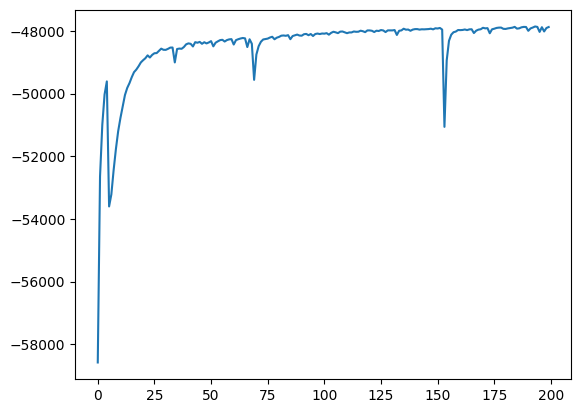

In [44]:
plt.plot(np.arange(len(logf)), logf)

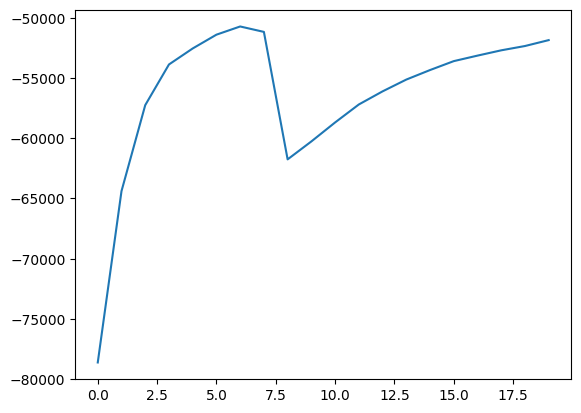

In [40]:
plt.plot(np.arange(len(logf)), logf)

In [38]:
sg_2019 = m.predict_onoffgp(x_just_2019q1.loc[:, ['lat','lon','timestep','theme_1_pc', 'theme_2_pc', 'theme_3_pc', 'theme_4_pc', 'svi_pctile', 'neighbor_t-1', 'self_t-1']].values)
sg_2019 = sg_2019[0].numpy()

In [45]:
maes = []
xtop = []
m.samples=10
for quarter in range(1,4+1):
    test_x = deaths_gdf_with_autoregressive[(deaths_gdf_with_autoregressive['year']==2019) & (deaths_gdf_with_autoregressive['quarter']==quarter)][['grid_squar','lat', 'lon', 'timestep', 'theme_1_pc', 'theme_2_pc', 'theme_3_pc', 'theme_4_pc', 'svi_pctile','neighbor_t-1', 'self_t-1']]
    test_y = deaths_gdf_with_autoregressive[(deaths_gdf_with_autoregressive['year']==2019) & (deaths_gdf_with_autoregressive['quarter']==quarter)][['grid_squar','timestep', 'deaths']]
    _, _, _, fmean, fvar, gmean, gvar, _, _ = m.build_predict(test_x.loc[:, ['lat','lon','timestep','theme_1_pc', 'theme_2_pc', 'theme_3_pc', 'theme_4_pc', 'svi_pctile', 'neighbor_t-1', 'self_t-1']].values)
    sg_2019 = tf.math.softplus(fmean*normcdf(gmean)+2).numpy()
    pred_2019_df = pd.Series(sg_2019.squeeze(), index=x_just_2019q1.grid_squar)

    maes.append(mean_absolute_error(test_y.deaths, pred_2019_df))
    xtop.append(fixed_top_X(test_y.set_index('grid_squar')['deaths'], pred_2019_df, 100))
print(np.mean(maes))
print(np.mean([thing[3] for thing in xtop]))

114.68088581123891
0.3281553929386747


In [186]:
xtop

[(164.0, 0.03529411764705882, 164.0, 0.03529411764705881),
 (161.0, 0.05847953216374269, 161.0, 0.05847953216374269),
 (178.0, 0.0481283422459893, 178.0, 0.04812834224598929),
 (170.0, 0.05555555555555555, 170.0, 0.05555555555555557)]

In [29]:
def normcdf(x):
    return 0.5 * (1.0 + tf.math.erf(x / np.sqrt(2.0))) * (1. - 2.e-3) + 1.e-3
_, _, _, fmean, fvar, gmean, gvar, _, _ = m.build_predict(x_just_2019q1.loc[:, ['lat','lon','timestep','theme_1_pc', 'theme_2_pc', 'theme_3_pc', 'theme_4_pc', 'svi_pctile', 'neighbor_t-1', 'self_t-1']].values)
sg_2019 = tf.math.softplus(fmean*normcdf(gmean)+2).numpy()

In [54]:
np.max(gmean)

2.410151803657639

In [55]:
sg_2019.min()

0.0

In [56]:
(fmean>0).numpy().max()

False

In [53]:
pred_2019_df = pd.Series(sg_2019.squeeze(), index=x_just_2019q1.grid_squar)


In [78]:
y_just_2019q1

,grid_squar,timestep,deaths
76,25001010100,76.0,0.0
164,25001010206,76.0,0.0
252,25001010208,76.0,0.0
340,25001010304,76.0,0.0
428,25001010306,76.0,0.0
...,...,...,...
142196,25027761100,76.0,0.0
142284,25027761200,76.0,0.0
142372,25027761300,76.0,1.0
142460,25027761401,76.0,0.0


In [156]:
sg_MAE_2019 = mean_absolute_error(y_just_2019q1.deaths, pred_2019_df)

sg_MLAE_2019 = mean_log_absolute_error(y_just_2019q1.deaths, pred_2019_df)

sg_top_10_2019 = top_X(y_just_2019q1.set_index('grid_squar')['deaths'], pred_2019_df, 10)
sg_top_50_2019 = top_X(y_just_2019q1.set_index('grid_squar')['deaths'], pred_2019_df, 50)
sg_top_100_2019 = fixed_top_X(y_just_2019q1.set_index('grid_squar')['deaths'], pred_2019_df, 100)

In [157]:
sg_MAE_2019

0.2774987623714301

In [158]:
sg_top_10_2019

(32.0, 0.0, 32.0, 0.0)

In [159]:
sg_top_100_2019

(164.0, 0.03529411764705882, 164.0, 0.03529411764705881)

In [83]:
def mean_log_absolute_error(y_true, y_pred):
    
    min_val = abs(min(min(y_true), min(y_pred))) + 1

    return np.average(np.abs(np.log(y_pred.values+min_val) -
                             np.log(y_true.values+min_val)), axis=0)
def top_X(y_true, y_pred, X=10):
    
    top_X_predicted = y_pred.sort_values(ascending=False)[:X]
    top_X_true = y_true.sort_values(ascending=False)[:X]
    
    undisputed_top_predicted = top_X_predicted[top_X_predicted>top_X_predicted.min()]
    num_tied_spots = X - len(undisputed_top_predicted)
    undisputed_top_true = top_X_true[top_X_true > top_X_true.min()]
    num_true_ties = X - len(undisputed_top_true)
    
    tied_top_predicted = top_X_predicted[top_X_predicted==top_X_predicted.min()]
    tied_top_true = top_X_true[top_X_true==top_X_true.min()]
    
    error_in_top_true_ties = np.abs(tied_top_true-y_pred[tied_top_true.index]).sort_values(ascending=True)
    error_in_top_pred_ties = np.abs(y_true[tied_top_predicted.index]-tied_top_predicted).sort_values(ascending=True)
    top_true_tied_geoids = error_in_top_true_ties[:num_true_ties].index
    top_pred_tied_geoids = error_in_top_pred_ties[:num_tied_spots].index

    best_possible_top_true_geoids = pd.Index.union(undisputed_top_true.index, top_true_tied_geoids)
    best_possible_top_pred_geoids = pd.Index.union(undisputed_top_predicted.index, top_pred_tied_geoids)
    
    # True values of GEOIDS with highest actual deaths. If ties, finds tied locations that match preds best
    best_possible_true = y_true[best_possible_top_true_geoids]
    best_possible_pred = y_true[best_possible_top_pred_geoids]

    assert(len(best_possible_true)==X)
    assert(len(best_possible_pred)==X)
    
    best_possible_absolute = np.abs(best_possible_true.sum() - best_possible_pred.sum())
    best_possible_ratio = np.abs(best_possible_pred).sum()/np.abs(best_possible_true).sum()
    
    
    bootstrapped_tied_indices = np.random.choice(tied_top_predicted.index, (1000, num_tied_spots))
    bootstrapped_all_indices =  [pd.Index.union(undisputed_top_predicted.index,
                                                bootstrap_index) for bootstrap_index in bootstrapped_tied_indices]
    
    bootstrapped_absolute = np.mean([np.abs(top_X_true.sum() - y_true[indices].sum()) 
                                     for indices in bootstrapped_all_indices])
    bootstrapped_ratio = np.mean([np.abs(y_true[indices]).sum()/np.abs(top_X_true).sum()
                                  for indices in bootstrapped_all_indices])
    
    return best_possible_absolute, best_possible_ratio, bootstrapped_absolute, bootstrapped_ratio

In [84]:
print(sg_MAE_2019 )

print(sg_MLAE_2019 )

print(sg_top_10_2019 [0])
print(sg_top_50_2019[0])
print(sg_top_100_2019 [0])
print(sg_top_10_2019 [1])
print(sg_top_50_2019[1])
print(sg_top_100_2019 [1])


86.88631969058476
0.13217335058681473
32.0
110.0
163.0
0.0
0.017857142857142856
0.041176470588235294


In [34]:
deaths_and_preds = y_just_2019.merge(pred_2019_df.rename('pred_deaths'),left_on='grid_squar', right_index=True)

In [35]:
deaths_and_preds.loc[:,'residuals'] = deaths_and_preds.deaths-deaths_and_preds.pred_deaths

In [36]:
residual_gdf = just_grid.merge(deaths_and_preds, on='grid_squar')

NameError: name 'sg_MAE_2019' is not defined

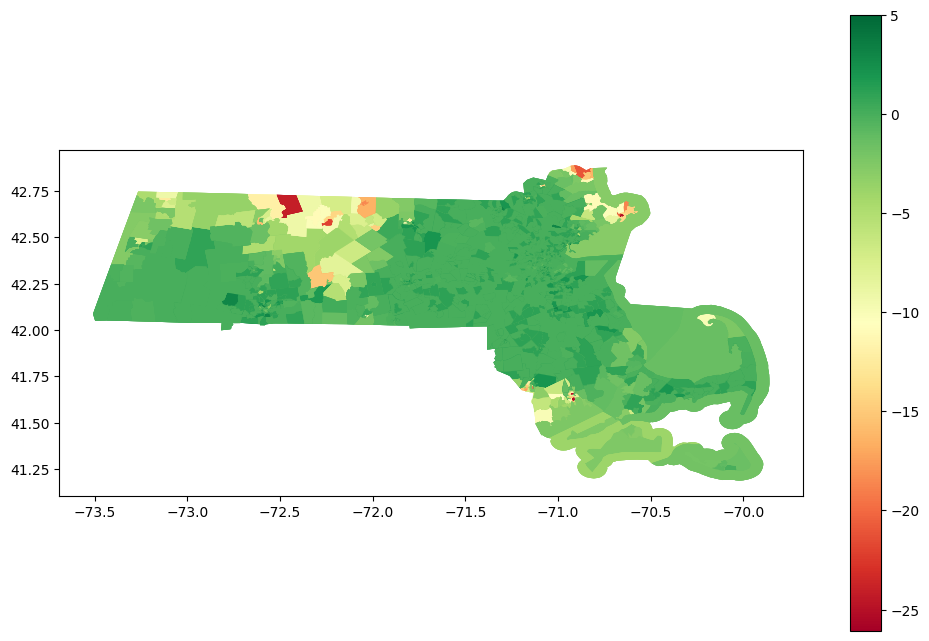

In [37]:
fig, ax = plt.subplots(1, 1, figsize=(12,8))
residual_gdf.plot(column='residuals', cmap='RdYlGn',ax=ax, legend=True,)
                 #vmin=-20, vmax=20)
plt.title(f'2019 Residuals from Sparse Zero-Inflated GP MAE {sg_MAE_2019:.2f}')


In [ ]:
residual_gdf.residuals.min()

In [ ]:
comparisons = pd.read_csv(os.path.join(result_dir,'comparisons.csv'))
comparisons

In [ ]:
fig, axs = plt.subplots(ncols=2, nrows=4, figsize=(10,10))
fig.tight_layout()
plt.subplots_adjust(hspace=0.5)
for c, comparison in comparisons.iterrows():
    row = int(np.floor(c/2))
    col = c%2
    ax = axs[row, col]
    

    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax.set_ylim([0,30])
    ax.set_title(comparison['name'])
        
    avg =  train_y_through_2019[train_y_through_2019['grid_squar']==comparison['center']].groupby('year').mean()['deaths']
    ax.plot(np.arange(2001, 2020), avg, 'k.-')
    
    ax.plot(2019, pred_2019_df.loc[comparison['center']],'ro', label='GP')
    ax.plot(2019,train_y_through_2019[(train_y_through_2019['grid_squar']==comparison['center'])&(train_y_through_2019['year']==2018)]['deaths'],'gx', label='t-1')
    if row==col==0:
        ax.legend()
fig.suptitle("Data for comparison locations, 2001-2019",y=1.05)

In [ ]:
pred_2019_df

In [ ]:
train_y_through_2019[(train_y_through_2019['grid_squar']==comparison['center'])&(train_y_through_2019['year']==2018)]['deaths']

In [ ]:
import scipy

In [ ]:
scipy.__version__

In [ ]:
m.savemodel?

In [61]:
m.savemodel('/cluster/home/kheuto01/testsavemodelpoi2.mod')

In [60]:
dir(m)

['ProbitExpectations',
 'X',
 'Xtrain',
 'Y',
 'Ytrain',
 'Zf',
 'Zg',
 '_TF_MODULE_IGNORED_PROPERTIES',
 '__abstractmethods__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__slotnames__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abc_impl',
 '_add_trackable_child',
 '_add_variable_with_custom_getter',
 '_checkpoint_dependencies',
 '_deferred_dependencies',
 '_delete_tracking',
 '_deserialization_dependencies',
 '_deserialize_from_proto',
 '_export_to_saved_model_graph',
 '_flatten',
 '_gather_saveables_for_checkpoint',
 '_handle_deferred_dependencies',
 '_lookup_dependency',
 '_map_resources',
 '_maybe_initialize_trackable',
 '_name',
 '_name_based_attribute_restore',
 '_name_based_restores',
 '_name_

In [ ]:
OnOffSVGP.update_feed_dict?

In [ ]:
m.set_parameter_dict?

In [ ]:
with open('/cluster/home/kheuto01/testsavemodel.mod','rb') as f:
    stuff = pickle.load(f)

In [ ]:
import pickle

In [ ]:
stuff

In [ ]:
train_x_through_2018.loc[:, ['lat','lon','timestep','theme_1_pc', 'theme_2_pc',
                                           'theme_3_pc', 'theme_4_pc', 'svi_pctile',
                                           'neighbor_t-1', 'self_t-1']].values.astype(np.float32)

In [31]:
def fixed_top_X(true_qtr_val,pred_qtr_val, X=10):
    
    top_X_predicted = pred_qtr_val.sort_values(ascending=False)[:X]
    top_X_true = true_qtr_val.sort_values(ascending=False)[:X]


    undisputed_top_predicted = top_X_predicted[top_X_predicted>top_X_predicted.min()]
    num_tied_spots = X - len(undisputed_top_predicted)
    undisputed_top_true = top_X_true[top_X_true > top_X_true.min()]
    num_true_ties = X - len(undisputed_top_true)


    tied_top_predicted = pred_qtr_val[pred_qtr_val==top_X_predicted.min()]
    tied_top_true = true_qtr_val[true_qtr_val==top_X_true.min()]

    error_in_top_true_ties = np.abs(tied_top_true-pred_qtr_val[tied_top_true.index]).sort_values(ascending=True)
    error_in_top_pred_ties = np.abs(true_qtr_val[tied_top_predicted.index]-tied_top_predicted).sort_values(ascending=True)
    top_true_tied_geoids = error_in_top_true_ties[:num_true_ties].index
    top_pred_tied_geoids = error_in_top_pred_ties[:num_tied_spots].index

    best_possible_top_true_geoids = pd.Index.union(undisputed_top_true.index, top_true_tied_geoids)
    best_possible_top_pred_geoids = pd.Index.union(undisputed_top_predicted.index, top_pred_tied_geoids)

    # True values of GEOIDS with highest actual deaths. If ties, finds tied locations that match preds best
    best_possible_true = true_qtr_val[best_possible_top_true_geoids]
    best_possible_pred = true_qtr_val[best_possible_top_pred_geoids]

    assert(len(best_possible_true)==X)
    assert(len(best_possible_pred)==X)

    best_possible_absolute = np.abs(best_possible_true.sum() - best_possible_pred.sum())
    best_possible_ratio = np.abs(best_possible_pred).sum()/np.abs(best_possible_true).sum()


    bootstrapped_tied_indices = np.random.choice(tied_top_predicted.index, (1000, num_tied_spots))
    bootstrapped_all_indices =  [pd.Index.union(undisputed_top_predicted.index,
                                                bootstrap_index) for bootstrap_index in bootstrapped_tied_indices]

    bootstrapped_absolute = np.mean([np.abs(top_X_true.sum() - true_qtr_val[indices].sum()) 
                                     for indices in bootstrapped_all_indices])
    bootstrapped_ratio = np.mean([np.abs(true_qtr_val[indices]).sum()/np.abs(top_X_true).sum()
                                  for indices in bootstrapped_all_indices])
    
    return best_possible_absolute, best_possible_ratio, bootstrapped_absolute, bootstrapped_ratio

In [189]:
true_debug = test_y.set_index('grid_squar')['deaths']
pred_debug = pred_2019_df

In [201]:
X=100
top_X_predicted = pred_debug.sort_values(ascending=False)[:X]
top_X_true = true_debug.sort_values(ascending=False)[:X]


undisputed_top_predicted = top_X_predicted[top_X_predicted>top_X_predicted.min()]
num_tied_spots = X - len(undisputed_top_predicted)
undisputed_top_true = top_X_true[top_X_true > top_X_true.min()]
num_true_ties = X - len(undisputed_top_true)


tied_top_predicted = pred_debug[pred_debug==top_X_predicted.min()]
tied_top_true = true_debug[true_debug==top_X_true.min()]

error_in_top_true_ties = np.abs(tied_top_true-pred_debug[tied_top_true.index]).sort_values(ascending=True)
error_in_top_pred_ties = np.abs(true_debug[tied_top_predicted.index]-tied_top_predicted).sort_values(ascending=True)
top_true_tied_geoids = error_in_top_true_ties[:num_true_ties].index
top_pred_tied_geoids = error_in_top_pred_ties[:num_tied_spots].index


best_possible_top_true_geoids = pd.Index.union(undisputed_top_true.index, top_true_tied_geoids)
best_possible_top_pred_geoids = pd.Index.union(undisputed_top_predicted.index, top_pred_tied_geoids)

# True values of GEOIDS with highest actual deaths. If ties, finds tied locations that match preds best
best_possible_true = true_debug[best_possible_top_true_geoids]
best_possible_pred = true_debug[best_possible_top_pred_geoids]

assert(len(best_possible_true)==X)
assert(len(best_possible_pred)==X)

best_possible_absolute = np.abs(best_possible_true.sum() - best_possible_pred.sum())
best_possible_ratio = np.abs(best_possible_pred).sum()/np.abs(best_possible_true).sum()


bootstrapped_tied_indices = np.random.choice(tied_top_predicted.index, (1000, num_tied_spots))
bootstrapped_all_indices =  [pd.Index.union(undisputed_top_predicted.index,
                                            bootstrap_index) for bootstrap_index in bootstrapped_tied_indices]

bootstrapped_absolute = np.mean([np.abs(top_X_true.sum() - true_debug[indices].sum()) 
                                 for indices in bootstrapped_all_indices])
bootstrapped_ratio = np.mean([np.abs(true_debug[indices]).sum()/np.abs(top_X_true).sum()
                              for indices in bootstrapped_all_indices])

In [206]:
np.abs(true_debug[best_possible_top_pred_geoids]).sum()

10.0

In [214]:
true_debug[best_possible_top_true_geoids].sum()

180.0

In [181]:
(pred_2019_df==0).mean()

0.001851851851851852

In [221]:
residual_gdf

,grid_squar,geometry,lat,lon,haversine,timestep,deaths,pred_deaths,residuals
0,25017333300,"POLYGON ((-71.16139 42.47071, -71.16136 42.471...",42.470764,-71.152055,17.535029,76.0,1.0,3.063715e-51,1.000000e+00
1,25017333300,"POLYGON ((-71.16139 42.47071, -71.16136 42.471...",42.470764,-71.152055,17.535029,77.0,0.0,3.063715e-51,-3.063715e-51
2,25017333300,"POLYGON ((-71.16139 42.47071, -71.16136 42.471...",42.470764,-71.152055,17.535029,78.0,1.0,3.063715e-51,1.000000e+00
3,25017333300,"POLYGON ((-71.16139 42.47071, -71.16136 42.471...",42.470764,-71.152055,17.535029,79.0,1.0,3.063715e-51,1.000000e+00
4,25017333400,"POLYGON ((-71.14690 42.48077, -71.14673 42.480...",42.484548,-71.132032,15.349759,76.0,0.0,2.720846e-43,-2.720846e-43
...,...,...,...,...,...,...,...,...,...
6475,25009208402,"POLYGON ((-71.05389 42.47878, -71.05373 42.479...",42.466251,-71.035971,14.958021,79.0,1.0,5.438075e-33,1.000000e+00
6476,25009212102,"POLYGON ((-71.05935 42.60633, -71.05916 42.607...",42.600718,-71.030823,0.000000,76.0,0.0,2.561700e-38,-2.561700e-38
6477,25009212102,"POLYGON ((-71.05935 42.60633, -71.05916 42.607...",42.600718,-71.030823,0.000000,77.0,0.0,2.561700e-38,-2.561700e-38
6478,25009212102,"POLYGON ((-71.05935 42.60633, -71.05916 42.607...",42.600718,-71.030823,0.000000,78.0,0.0,2.561700e-38,-2.561700e-38


NameError: name 'residual_gdf' is not defined

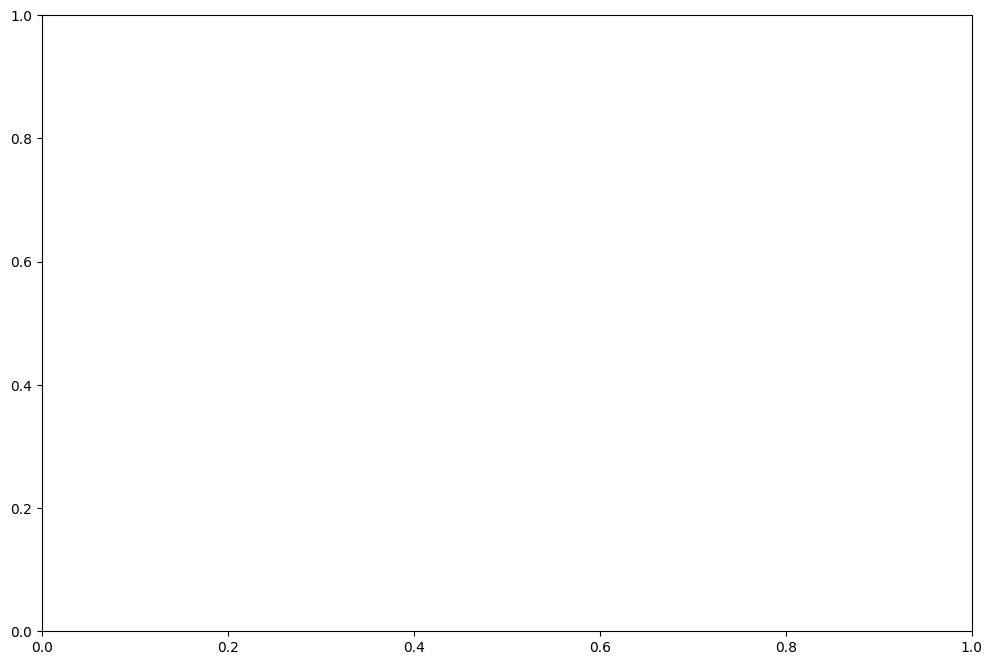

In [51]:
fig, ax = plt.subplots(1, 1, figsize=(12,8))
residual_gdf.plot(column='pred_deaths', cmap='RdYlGn',ax=ax, legend=True,)
                 #vmin=-20, vmax=20)
plt.title(f'2019Q1 Predicted Deaths from Sparse Zero-Inflated GP Poisson')


In [49]:
_, _, _, fmean, fvar, gmean, gvar, _, _ = m.build_predict(x_just_2019q1.loc[:, ['lat','lon','timestep','theme_1_pc', 'theme_2_pc', 'theme_3_pc', 'theme_4_pc', 'svi_pctile', 'neighbor_t-1', 'self_t-1']].values)

data_shape =fmean.shape
u = tf.random.normal(shape=data_shape + (m.samples,), dtype=gpflow.config.default_float())
w = tf.random.normal(shape=data_shape + (m.samples,), dtype=gpflow.config.default_float())

# Expand dims to give the mean a sample dimension
g_mean_NDS = tf.expand_dims(gmean, -1)
g_std_NDS = tf.expand_dims(tf.math.sqrt(gvar), -1)
g_samples = g_mean_NDS + u * g_std_NDS
del u
phi_g_samples = normcdf(g_samples)
del g_samples

f_mean_NDS = tf.expand_dims(fmean, -1)
f_var_NDS = tf.expand_dims(fvar, -1)
f_std_NDS = tf.math.sqrt(f_var_NDS)
f_samples = f_mean_NDS * phi_g_samples + w * f_std_NDS * phi_g_samples

shifted_softplus_f_samples = tf.math.softplus(f_samples+2)

In [50]:
shifted_softplus_f_samples

<tf.Tensor: shape=(1620, 1, 10), dtype=float64, numpy=
array([[[3.66963228e-26, 3.40189528e-15, 1.01211671e-31, ...,
         2.86691493e-47, 4.14967669e-26, 4.61795636e-52]],

       [[1.69335769e-24, 2.11993543e-26, 3.43546084e-40, ...,
         2.00715549e-16, 4.33790468e-68, 2.60146827e-22]],

       [[2.71814081e-14, 1.31627416e-34, 2.30896688e-30, ...,
         9.37325031e-35, 8.62173925e-31, 1.11034840e-27]],

       ...,

       [[1.91258665e-11, 7.46977293e-18, 5.96632382e-19, ...,
         5.47489493e-14, 1.34233854e-18, 1.01302813e-09]],

       [[2.51464199e-30, 2.08445802e-30, 6.77619819e-29, ...,
         3.46854585e-40, 4.04313732e-29, 8.30078696e-41]],

       [[1.76685062e-35, 6.00444936e-21, 4.99974853e-32, ...,
         4.36673223e-20, 1.63417345e-18, 2.45616982e-71]]])>

In [48]:
u

<tf.Tensor: shape=(1620, 1, 10), dtype=float32, numpy=
array([[[-2.2318321e-03, -1.4853112e+00, -9.7724938e-01, ...,
         -1.0088767e+00, -3.0112901e-01, -1.8586321e+00]],

       [[-2.9343958e+00,  4.4987887e-01,  5.5495602e-01, ...,
         -1.1789962e+00, -1.4586662e+00, -7.4966139e-01]],

       [[ 7.2377878e-01,  1.3453177e+00,  1.7865726e+00, ...,
         -5.8935326e-01, -1.4164627e+00, -8.9788830e-01]],

       ...,

       [[ 1.2451640e+00, -6.1772966e-01, -1.6144687e-01, ...,
          5.4002357e-01, -6.3023843e-02, -1.8380572e-01]],

       [[ 5.6231660e-01,  1.5454016e+00, -1.2034699e+00, ...,
          9.6673042e-01, -4.5651799e-01, -4.0009081e-01]],

       [[-3.6452210e-01,  2.5573165e+00,  6.2331474e-01, ...,
         -2.4855416e-01, -1.5298824e+00,  1.9678928e+00]]], dtype=float32)>

In [243]:
conditionals.conditional(x_just_2019q1.loc[:, ['lat','lon','timestep','theme_1_pc', 'theme_2_pc', 'theme_3_pc', 'theme_4_pc', 'svi_pctile', 'neighbor_t-1', 'self_t-1']].values,
                         m.Zf, m.kernf, m.u_fm,
                                               full_cov=False, q_sqrt=m.u_fs_sqrt, )

(<tf.Tensor: shape=(1620, 1), dtype=float64, numpy=
 array([[-550.16518358],
        [-367.8704305 ],
        [-412.30488097],
        ...,
        [-268.5206657 ],
        [-236.76094593],
        [-298.20051076]])>,
 <tf.Tensor: shape=(1620, 1), dtype=float64, numpy=
 array([[1253.67480186],
        [ 625.99020657],
        [ 776.34196785],
        ...,
        [ 322.09867865],
        [ 269.34043217],
        [ 403.08785588]])>)

In [242]:
from gpflow import conditionals

In [244]:
m.u_fs_sqrt

<Parameter: name=softplus, dtype=float64, shape=[200, 1], fn="softplus", numpy=
array([[1.12261586],
       [1.71523168],
       [1.37140642],
       [0.72761354],
       [0.75187411],
       [0.30777005],
       [2.3456323 ],
       [0.97191191],
       [1.44255191],
       [1.46511116],
       [1.10359442],
       [1.49322489],
       [1.05751241],
       [1.3451695 ],
       [2.27475727],
       [0.89554643],
       [3.0107376 ],
       [1.96870095],
       [0.85035038],
       [2.3099594 ],
       [0.65384465],
       [1.58429328],
       [0.69346249],
       [0.65076861],
       [2.38344991],
       [0.72901233],
       [1.42930144],
       [0.80066937],
       [0.53116897],
       [1.03794957],
       [1.49450984],
       [1.45596496],
       [1.28948695],
       [1.78365039],
       [0.69391163],
       [1.53364287],
       [1.79979718],
       [2.95501382],
       [0.62588839],
       [1.67138249],
       [1.17194368],
       [0.66301201],
       [1.80464822],
       [2.0896520

In [57]:
m.u_fm

<Parameter: name=identity, dtype=float64, shape=[200, 1], fn="identity", numpy=
array([[-0.31227832],
       [-0.40971456],
       [-0.44709105],
       [ 0.9431374 ],
       [ 1.42212097],
       [-1.98285844],
       [-0.27367395],
       [-0.3733846 ],
       [-1.66139194],
       [-1.53938829],
       [-1.65409221],
       [-1.86232676],
       [-1.35220767],
       [-0.19886791],
       [-0.23680251],
       [ 1.40085557],
       [ 0.01304578],
       [-0.14135827],
       [-0.20390934],
       [-0.16125234],
       [ 0.21183154],
       [-1.08487605],
       [-0.83836578],
       [ 0.95393502],
       [-0.55038893],
       [ 0.64950049],
       [-0.41235334],
       [-1.13868232],
       [ 0.84019486],
       [-1.28280777],
       [ 0.15000162],
       [-0.69024139],
       [ 0.42047912],
       [-0.79926154],
       [-0.42499421],
       [-0.68446315],
       [-0.2539238 ],
       [-0.10227372],
       [-0.7534487 ],
       [-1.03389286],
       [-1.05230105],
       [-0.8637010

In [75]:
fmean.numpy().mean()

-295.0234342656407

(array([8.0000e+00, 1.5000e+01, 8.5000e+01, 3.5900e+02, 2.8580e+03,
        5.6180e+03, 1.2087e+04, 2.1218e+04, 6.1548e+04, 1.9324e+04]),
 array([-1464.82984636, -1313.32945712, -1161.82906787, -1010.32867862,
         -858.82828937,  -707.32790012,  -555.82751088,  -404.32712163,
         -252.82673238,  -101.32634313,    50.17404612]),
 <BarContainer object of 10 artists>)

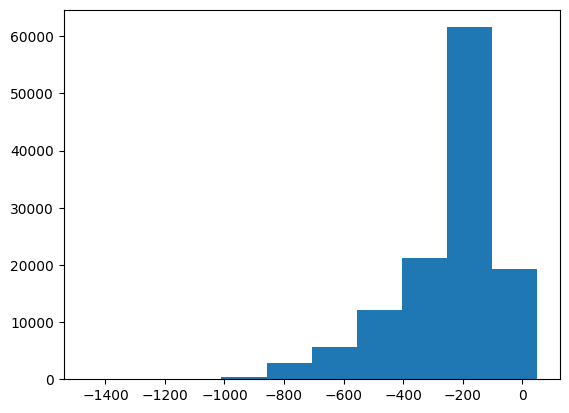

In [98]:
plt.hist(fmean.numpy())

In [65]:
np.arange(len(fmean.numpy())

SyntaxError: unexpected EOF while parsing (2420981783.py, line 1)

In [68]:
m.u_fm

<Parameter: name=identity, dtype=float64, shape=[200, 1], fn="identity", numpy=
array([[-0.31227832],
       [-0.40971456],
       [-0.44709105],
       [ 0.9431374 ],
       [ 1.42212097],
       [-1.98285844],
       [-0.27367395],
       [-0.3733846 ],
       [-1.66139194],
       [-1.53938829],
       [-1.65409221],
       [-1.86232676],
       [-1.35220767],
       [-0.19886791],
       [-0.23680251],
       [ 1.40085557],
       [ 0.01304578],
       [-0.14135827],
       [-0.20390934],
       [-0.16125234],
       [ 0.21183154],
       [-1.08487605],
       [-0.83836578],
       [ 0.95393502],
       [-0.55038893],
       [ 0.64950049],
       [-0.41235334],
       [-1.13868232],
       [ 0.84019486],
       [-1.28280777],
       [ 0.15000162],
       [-0.69024139],
       [ 0.42047912],
       [-0.79926154],
       [-0.42499421],
       [-0.68446315],
       [-0.2539238 ],
       [-0.10227372],
       [-0.7534487 ],
       [-1.03389286],
       [-1.05230105],
       [-0.8637010

In [74]:
m.Zf.numpy()[:,2]

array([ 5.60274996e+01,  5.75514577e+01,  5.90594871e+01,  5.58786663e+01,
        1.30211041e+01,  1.77583480e+00,  3.07064316e+01,  2.20290627e+01,
        4.32109092e+01,  3.68474067e+01,  6.72412466e+01,  6.16869594e+01,
        2.91284537e+01,  6.42545003e+01,  4.97692349e+01,  3.08425586e+00,
        7.34686758e+01,  3.04028669e+01,  3.29454627e+01,  5.46177508e+01,
        3.51802857e+01,  2.81491321e+01,  4.00495091e+01,  1.20961460e+01,
        6.10350769e+01,  3.16098944e+00,  9.96202799e-02,  6.57957142e+01,
        4.48391637e+01,  4.09260202e+01,  6.32849961e+01,  7.10648793e+01,
        4.64250658e+01,  1.79991771e+01,  7.19528507e+01,  5.53551709e+01,
        3.14617509e-01,  6.54507867e+01,  4.96476497e+01,  2.54323601e+01,
        2.29667806e+01,  3.30217793e+01,  1.69255887e+00,  2.04863996e+01,
        3.21544861e+01,  5.38774762e+01,  6.79240762e+01,  2.90036263e+01,
        7.91750800e+00,  8.28268265e-01,  6.52034790e+01,  1.32453063e+00,
        1.49416090e+01,  

In [76]:
m.kernf

name,class,transform,prior,trainable,shape,dtype,value
Sum.kernels[0].variance,Parameter,Softplus,,True,(),float64,4.31418
Sum.kernels[0].lengthscales,Parameter,Softplus,,True,(),float64,0.457051
Sum.kernels[1].variance,Parameter,Softplus,,True,(),float64,1.96096
Sum.kernels[1].lengthscales,Parameter,Softplus,,True,(),float64,0.892057
Sum.kernels[2].variance,Parameter,Softplus,,True,(),float64,5.85824
Sum.kernels[2].lengthscales,Parameter,Softplus,,True,(),float64,1.71412


In [80]:
conditionals.conditional(x_just_2019q1.loc[:, ['lat','lon','timestep','theme_1_pc', 'theme_2_pc', 'theme_3_pc', 'theme_4_pc', 'svi_pctile', 'neighbor_t-1', 'self_t-1']].values,
                         m.Zf, m.kernf, m.u_fm,
                                               full_cov=False, q_sqrt=m.u_fs_sqrt, )

(<tf.Tensor: shape=(1620, 1), dtype=float64, numpy=
 array([[-458.34125936],
        [-468.2405829 ],
        [-403.3528201 ],
        ...,
        [-260.29560234],
        [-283.36404601],
        [-301.24957175]])>,
 <tf.Tensor: shape=(1620, 1), dtype=float64, numpy=
 array([[7356.10960947],
        [6745.74855726],
        [5753.34177975],
        ...,
        [1792.65370044],
        [2163.64559681],
        [2418.03893018]])>)

In [79]:
from gpflow import conditionals

In [28]:
plt.plot(np.arange(len(m.Zf.numpy()[:,2])), time_inducing )

NameError: name 'time_inducing' is not defined

In [87]:
m.Zf.numpy()[:,2].shape

(200,)

In [96]:
time_inducing = m.Zf.numpy()[:,0]
time_inducing.sort()

In [100]:
m.kernf

name,class,transform,prior,trainable,shape,dtype,value
Sum.kernels[0].variance,Parameter,Softplus,,True,(),float64,4.31418
Sum.kernels[0].lengthscales,Parameter,Softplus,,True,(),float64,0.457051
Sum.kernels[1].variance,Parameter,Softplus,,True,(),float64,1.96096
Sum.kernels[1].lengthscales,Parameter,Softplus,,True,(),float64,0.892057
Sum.kernels[2].variance,Parameter,Softplus,,True,(),float64,5.85824
Sum.kernels[2].lengthscales,Parameter,Softplus,,True,(),float64,1.71412


In [101]:
maes

[0.27598030560932973,
 0.27889824097968513,
 0.2874553856207952,
 0.3090660806819205]

In [107]:
stat_logs = pd.DataFrame()
stat_logs = stat_logs.append({'iter':step, 'mae':np.mean(maes), 'bpr_100': np.mean(xtop)}, ignore_index=True)

/tmp/ipykernel_83016/1656108407.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  stat_logs = stat_logs.append({'mae':np.mean(maes), 'bpr_100': np.mean(xtop)}, ignore_index=True)


In [108]:
stat_logs

,mae,bpr_100
0,0.28785,83.279827


In [27]:
with open('/cluster/tufts/hugheslab/kheuto01/opioid/logs/poi_savemod/ind200_kernelsvi_full_lr0.05/model.mod','rb') as f:
    m = pickle.load(f)

In [24]:
import pickle

In [42]:
m.build_prior_KL()

<tf.Tensor: shape=(), dtype=float64, numpy=114.04670575570906>

In [43]:
m.samples

10